In [1]:
import pandas as pd
import statsmodels.stats.multitest as multi

from CosinorPy import file_parser, cosinor, cosinor1
from CosinorPy.helpers import df_add_row

In [2]:
accidents = pd.read_csv("../PrometneNesreče.csv")

C:\Users\Hana\AppData\Local\Temp\ipykernel_43688\901670543.py:1: DtypeWarning: Columns (31,32,33,34,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  accidents = pd.read_csv("../PrometneNesreče.csv")


In [3]:
# Priprava podatkov
accidents['NastanekDatumCas'] = pd.to_datetime(accidents['NastanekDatumCas'], format='ISO8601', errors='coerce')
print(f"NastanekDatumCas column dtype: {accidents['NastanekDatumCas'].dtype}")

NastanekDatumCas column dtype: datetime64[ns]


# CosinorPy - poletje

In [6]:
summer_mask = accidents['NastanekDatumCas'].dt.month.isin([6, 7, 8])

summer_accidents = accidents[summer_mask]
# print(f"NastanekDatumCas column dtype: {summer_accidents['NastanekDatumCas'].dtype}")

hours = summer_accidents['NastanekDatumCas'].dt.hour

accidents_per_hour = hours.value_counts()
accidents_per_hour = accidents_per_hour.sort_index()

# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo CosinorPy
df_plot = pd.DataFrame({
    "test": "HourlyAccidentsSummer",  # konstantna oznaka vseh vrstic
    "x": accidents_per_hour.index,  # Ura (od 0 do 23)
    "y": accidents_per_hour.values  # Število nesreč za tisto uro
})

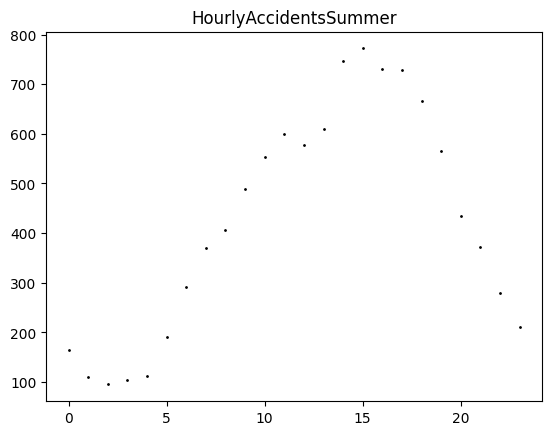

In [7]:
cosinor.plot_data(df_plot, names=["HourlyAccidentsSummer"])

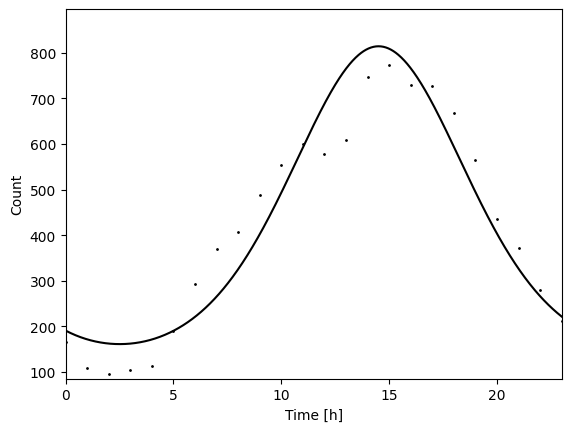

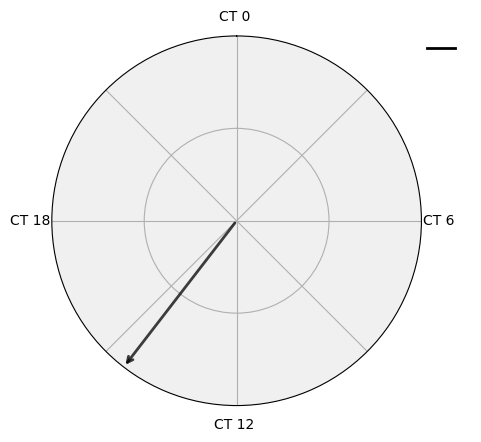

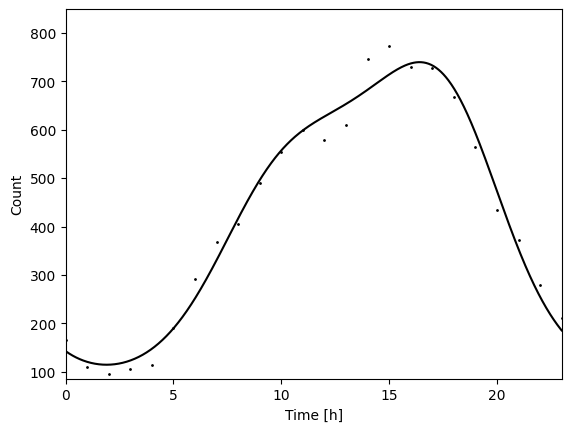

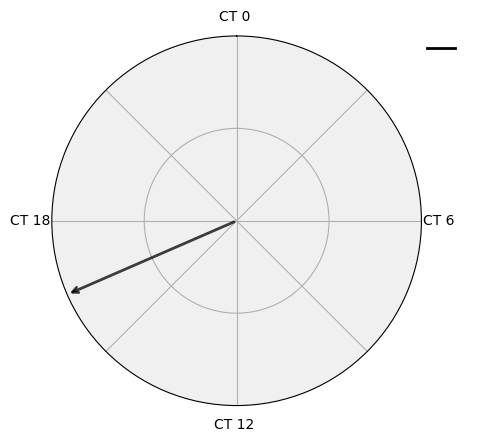

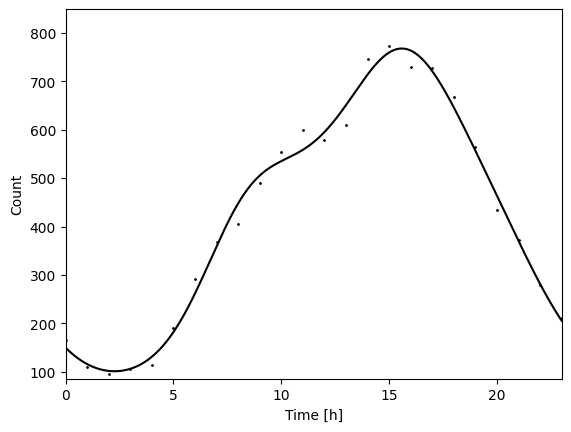

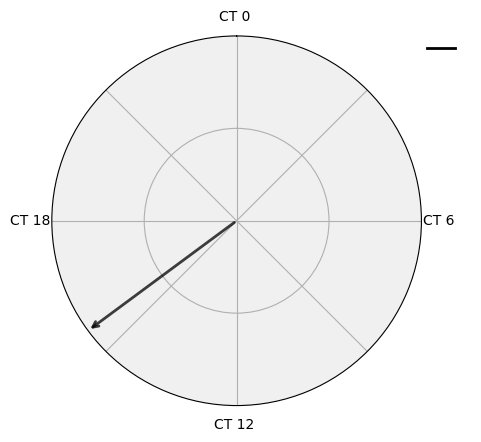

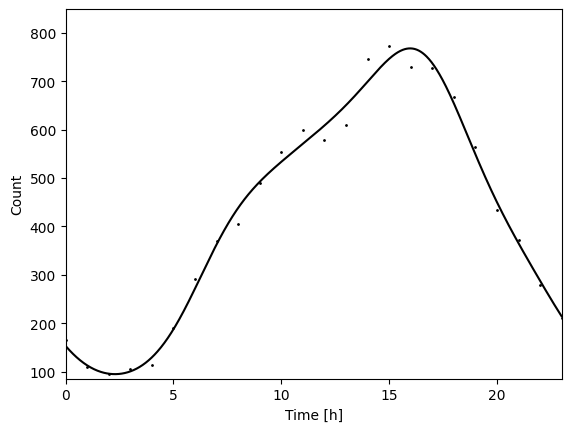

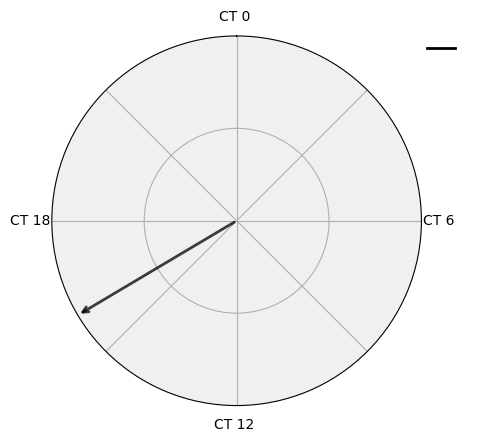

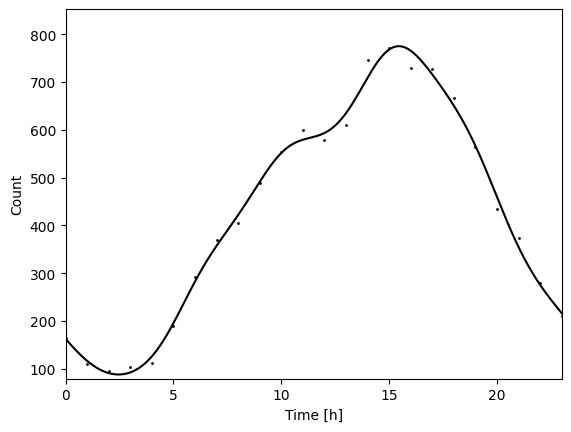

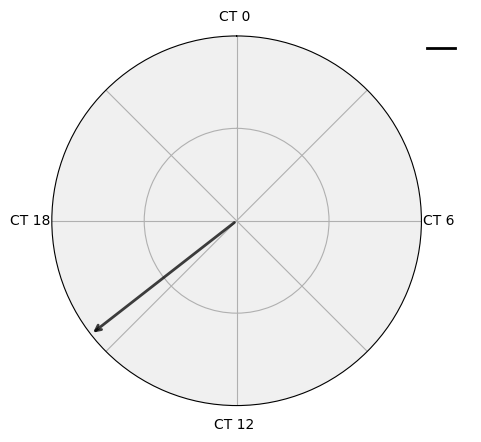

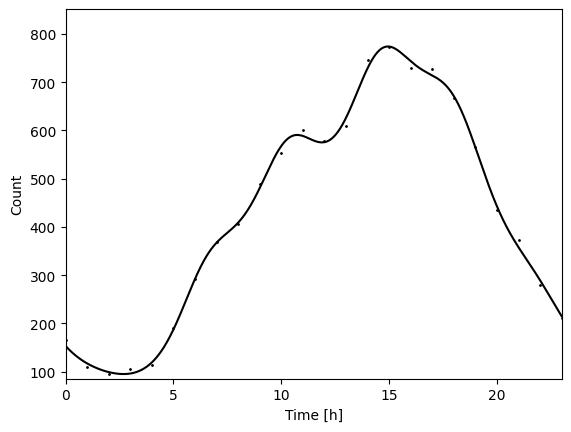

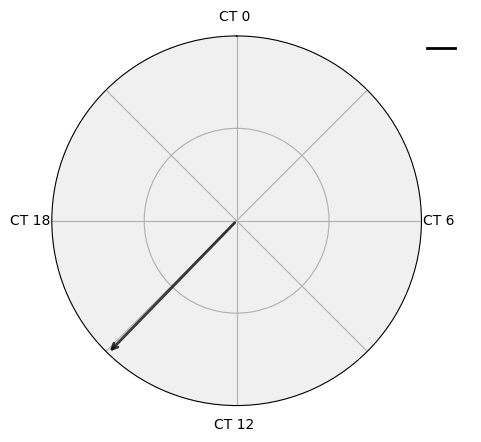

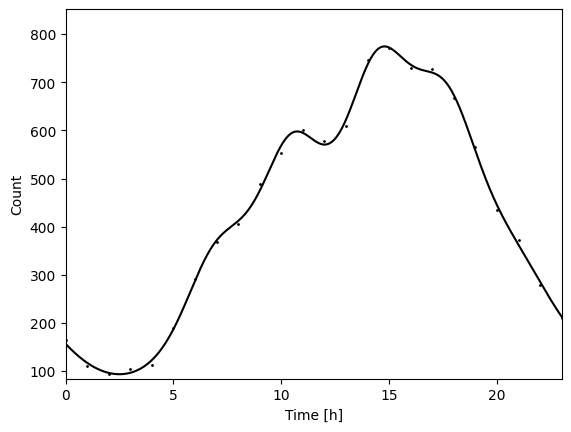

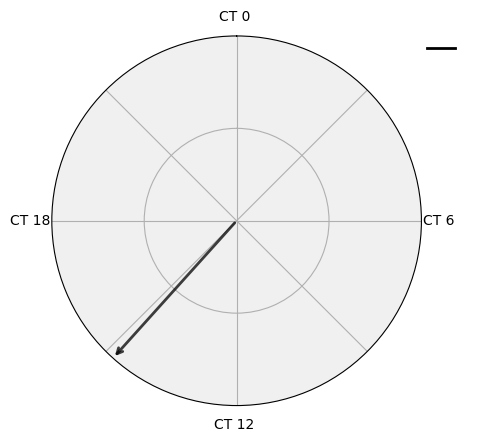

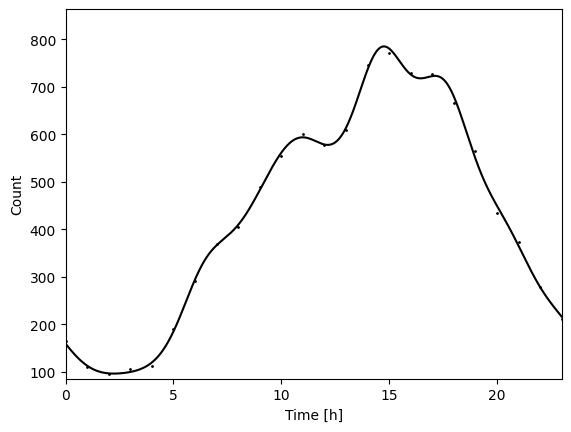

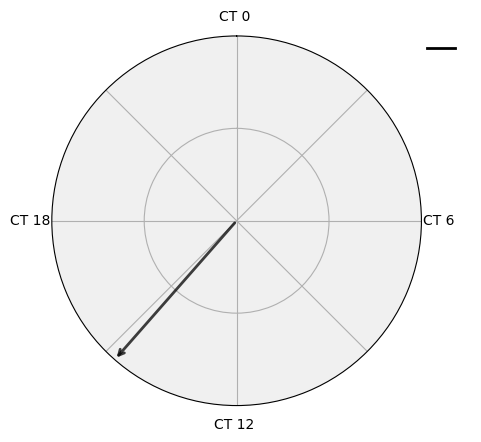

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


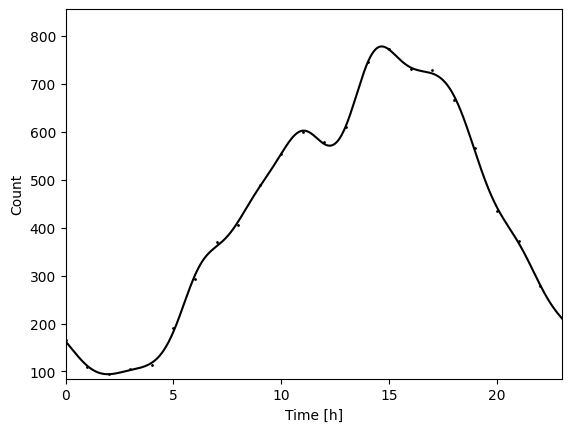

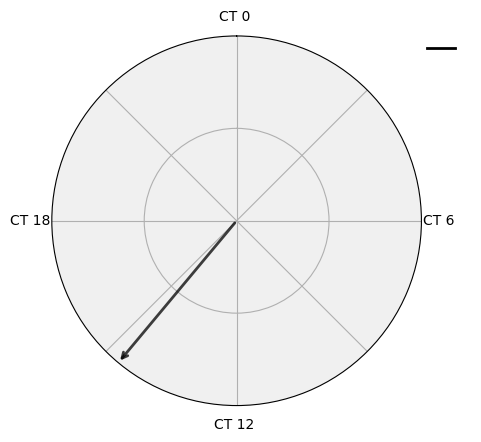

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


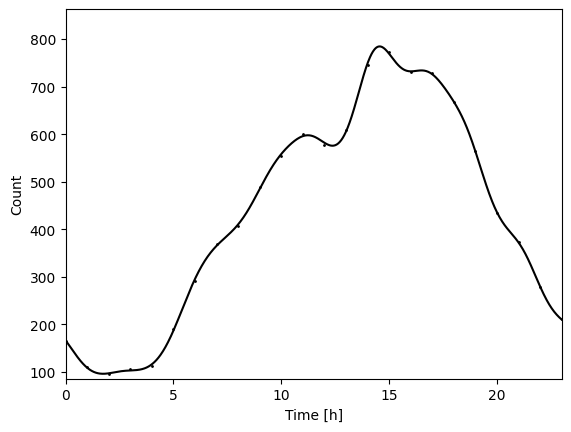

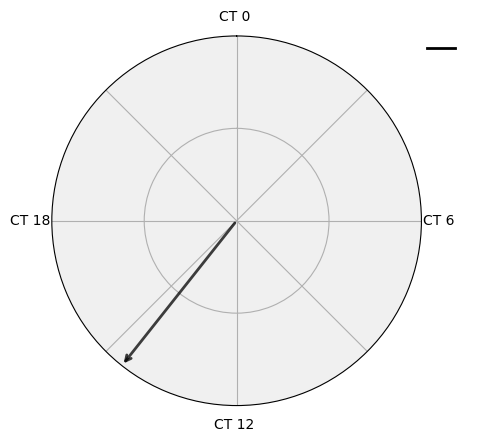

In [8]:
X = df_plot.x.to_numpy()
Y = df_plot.y.to_numpy()

df_results = pd.DataFrame(columns=[
    'test', 'period', 'n_components', 'p', 'q', 'RSS', 
    'log-likelihood', 'prsquared', 'amplitude', 'acrophase', 
    'mesor', 'peaks', 'heights', 'troughs', 'heights2'
], dtype=float)


numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for i in numbers:
    results, statistics, rhythm_param, _, _ = cosinor.fit_me(X, Y, n_components = i, period = 24, model_type = 'gen_poisson', plot_margins=False)
    #result_table.append(result)

    # print("Statistics:", statistics.keys())
    # print("Rhythm parameters:", rhythm_param.keys())
    # print("Results attributes:", dir(results))

    df_results = df_add_row(df_results, {
        'test': 'HourlyAccidentsSummer', 
        'period': 24,
        'n_components': i,
        'p': statistics['p'], 
        'RSS': statistics['RSS'],
        'log-likelihood': results.llf,        
        'prsquared': results.prsquared,  # Alternative to R²
        'amplitude': rhythm_param['amplitude'],
        'acrophase': rhythm_param['acrophase'],
        'mesor': rhythm_param['mesor'],
        'peaks': rhythm_param['peaks'],
        'heights': rhythm_param['heights'],
        'troughs': rhythm_param['troughs'],
        'heights2': rhythm_param['heights2']
    })


df_results.q = multi.multipletests(df_results.p, method = 'fdr_bh')[1]

In [9]:
display(df_results)

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidentsSummer,24.0,1.0,6.132495e-14,6.132495e-14,107323.341863,-134.803843,0.184127,326.306656,2.484343,487.670973,[14.51051051051051],[813.977628860914],[2.4984984984984986],[161.36431736816385]
1,HourlyAccidentsSummer,24.0,2.0,9.647840e-21,1.071982e-20,21878.120101,-115.206666,0.302735,312.610185,1.981185,427.029380,[16.43243243243243],[739.630617301198],[1.8738738738738738],[114.42300168362273]
2,HourlyAccidentsSummer,24.0,3.0,1.926986e-23,2.752837e-23,11562.889411,-105.399752,0.362089,333.439262,2.207606,434.387733,[15.567567567567567],[767.8196035196897],[2.2582582582582584],[100.94847053057434]
3,HourlyAccidentsSummer,24.0,4.0,4.276269e-23,5.345337e-23,11045.666962,-103.074422,0.376163,336.618718,2.106974,431.423113,[15.951951951951951],[768.028849999599],[2.3063063063063063],[94.80859527952687]
4,HourlyAccidentsSummer,24.0,5.0,4.596516e-24,7.660860e-24,6282.216471,-97.761130,0.408320,343.202703,2.232764,431.615874,[15.471471471471471],[774.8037431939238],[2.4504504504504503],[88.41317104150815]
5,HourlyAccidentsSummer,24.0,6.0,6.205830e-27,1.551457e-26,2132.012731,-87.861033,0.468239,339.351203,2.371132,434.532490,"[10.714714714714715, 14.942942942942944]","[590.5439397841573, 773.8836931852676]",[2.6906906906906904],[95.1812877666934]
6,HourlyAccidentsSummer,24.0,7.0,9.865735e-27,1.973147e-26,1596.366070,-85.582294,0.482030,340.403606,2.408869,433.972824,"[10.714714714714715, 14.7987987987988]","[597.7683290100363, 774.3686729071987]",[2.4984984984984986],[93.56921856168084]
7,HourlyAccidentsSummer,24.0,8.0,8.183186e-28,2.727729e-27,1250.995139,-80.195386,0.514633,344.547225,2.421448,440.845844,"[11.003003003003004, 14.75075075075075, 17.105...","[593.9396109418209, 785.3930685954786, 723.355...",[2.2582582582582584],[96.30219697787646]
8,HourlyAccidentsSummer,24.0,9.0,1.075636e-29,5.378180e-29,605.507910,-72.830879,0.559206,341.716023,2.446606,436.035020,"[11.05105105105105, 14.654654654654655]","[602.1933643801758, 777.7510428046243]",[1.96996996996997],[94.31899753339245]
9,HourlyAccidentsSummer,24.0,10.0,3.924875e-34,3.924875e-33,187.727795,-59.032687,0.642716,344.364036,2.471764,440.264128,"[11.243243243243244, 14.558558558558559, 16.48...","[597.7126389805161, 784.6281642195261, 734.121...",[1.7297297297297298],[95.9000922261005]


### Katero je najboljše število komponent

In [10]:
df_best_model = cosinor.get_best_models(df_plot, df_results, n_components = [1,2,3,4,5,6,7,8,9,10])
df_best_model

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidentsSummer,24.0,6.0,6.205830e-27,1.551457e-26,2132.012731,-87.861033,0.468239,339.351203,2.371132,434.53249,"[10.714714714714715, 14.942942942942944]","[590.5439397841573, 773.8836931852676]",[2.6906906906906904],[95.1812877666934]


c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\CosinorPy\cosinor.py:1659: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


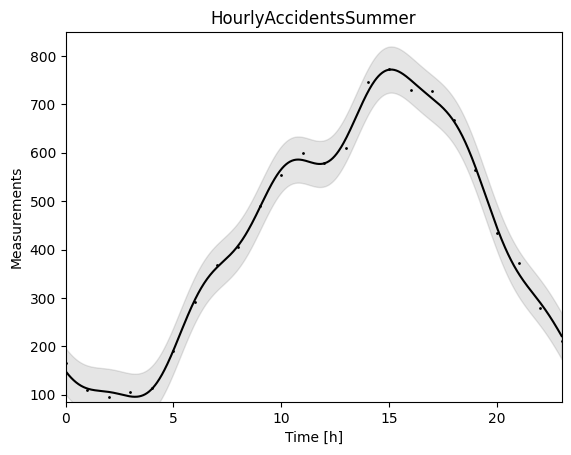

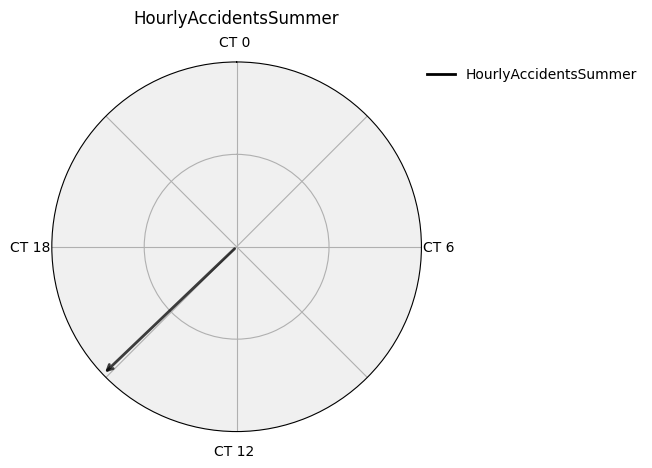

In [11]:
cosinor.plot_df_models(df_plot, df_best_model)